<a href="https://colab.research.google.com/github/Alexurm/Power-Generation-Projects/blob/main/Moscow_charging_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Зарядные станции Москвы

Данное исследование выполнено в целях анализа имеющихся в г.Москва зарядных станций для электромобилей.  
Данные взяты из открытого источника по ссылке:

https://data.mos.ru/opendata/7704786030-elektrozapravki/row/2566160457

Анализ данных выполняется в несколько шагов:

**Шаг 1. Загрузка данных**

Необходимо  подключиться к Google Drive для доступа к файлу, который содержит информацию о заправках. Наименование файла: `moscow_charging_network.xlsx`

**Шаг 2. Предобработка данных**

Необходимо рассмотреть данные и подготовить их для дальнейшего анализа:

*   удалить ненужные строки/столбцы
*   привести названия столбцов к единому стилю
*   проверить данные на пропуски
*   проверить данные на явные и неявные дубликаты
*   выполнить оптимизацию текстовых данных (при необходимости)
*   преобразовать к нужному типу данных

**Шаг 3. Исследовательский анализ данных**

 Необходимо рассмотреть, какие типы зарядных станций установлены в Москве, в каких районах и административных округах они расположены, в каком количестве.

 **Шаг 4. Визуализация геоданных**

 Требуется выполнить привязку местоположения зарядных станций к карте Москвы и проанализировать визуально характер их территориального распределения.

  **Шаг 5. Общий вывод**

 Основные наблюдения по итогам выполненного анализа данных.

## Загрузка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly import graph_objects as go

import geopandas as gpd
from geopandas import GeoDataFrame
import shapely
from shapely.ops import snap, unary_union
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point

In [2]:
# подключение к Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# чтение файла с данными и сохранение в df:
path = "/content/drive/MyDrive/Colab Notebooks/Данные/moscow_charging_network.xlsx"
df = pd.read_excel(path)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# получение первых 10 строк таблицы df:
df.head(10)

,object_category_Id,ID,Name,AdmArea,District,Address,Longitude_WGS84,Latitude_WGS84,global_id
0,object_category_Id,Код,Наименование,Административный округ,Район,Адрес,Долгота в WGS-84,Широта в WGS-84,global_id
1,NaN,2,"Станция №2, 22 кВт",Центральный административный округ,район Замоскворечье,"Российская Федерация, город Москва, внутригоро...",37.635730,55.734530,2566160457
2,NaN,71,"Станция №71, 22 кВт",Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655510,55.736310,2566160494
3,NaN,72,"Станция №72, 22 кВт",Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655608,55.736211,2566160642
4,NaN,73,"Станция №73, 50 кВт",Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.571088,55.743311,2566178202
5,NaN,74,"Станция №74, 50 кВт",Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.570948,55.743153,2566178211
6,NaN,75,"Станция №75, 50 кВт",Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.571189,55.743406,2566178212
7,NaN,78,"Станция №78, 50 кВт",Северный административный округ,район Беговой,"Российская Федерация, город Москва, внутригоро...",37.542159,55.785205,2566178213
8,NaN,79,"Станция №79, 22 кВт",Северо-Восточный административный округ,Бабушкинский район,"Российская Федерация, город Москва, внутригоро...",37.662035,55.869758,2566178214
9,NaN,80,"Станция №80, 22 кВт",Юго-Восточный административный округ,район Люблино,"город Москва, улица Верхние Поля, владение 39А...",37.767375,55.668741,2566178215


In [5]:
# получение общей информации
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   object_category_Id  1 non-null      object
 1   ID                  163 non-null    object
 2   Name                163 non-null    object
 3   AdmArea             163 non-null    object
 4   District            163 non-null    object
 5   Address             163 non-null    object
 6   Longitude_WGS84     163 non-null    object
 7   Latitude_WGS84      163 non-null    object
 8   global_id           163 non-null    object
dtypes: object(9)
memory usage: 11.6+ KB


Данные успешно загружены. Имеется следующий набор данных:
* `object_category_Id` - некий id объекта (скорее всего это просто общая категория инфраструктуры - в данном случае заправочные станции)
* `ID` - id (номер заправки)
* `Name` - содержит информацию о номере заправки (по сути дублирует информацию предыдущего столбца) и о мощности заправки в кВт (самая важная характеристика)
* `AdmArea` - административные округа Москвы
* `District` - районы Москвы
* `Address` - адрес электрозаправки
* `Longitude_WGS84` - долгота (для геопозиционирования)
* `Latitude_WGS84 ` - широта (для геопозиционирования)
* `global_id` - глобальный id электрозаправки

Потребуется выполнить предобработку данных, а именно:
* удалить лишнюю информацию из датасета
* разделить строковые данные из названия электрозаправок
* привести названия столбцов к змеиному регистру (snake case)
* проверить на пропуски
* проверить на дубликаты
* сократить названия административных округов и райнонов
* преобразовать тип данных

## Предобработка данных

### Удаление лишней информации

Размер датасета перед обработкой данных:

In [6]:
df.shape

(163, 9)

Всего имеется 9 колонок и 163 строки. Вторая строка по сути дублирует первую (пояснение на русском языке), предлагается ее удалить:

In [7]:
df = df.drop(index=0)

In [8]:
df.head()

,object_category_Id,ID,Name,AdmArea,District,Address,Longitude_WGS84,Latitude_WGS84,global_id
1,NaN,2,"Станция №2, 22 кВт",Центральный административный округ,район Замоскворечье,"Российская Федерация, город Москва, внутригоро...",37.635730,55.734530,2566160457
2,NaN,71,"Станция №71, 22 кВт",Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655510,55.736310,2566160494
3,NaN,72,"Станция №72, 22 кВт",Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655608,55.736211,2566160642
4,NaN,73,"Станция №73, 50 кВт",Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.571088,55.743311,2566178202
5,NaN,74,"Станция №74, 50 кВт",Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.570948,55.743153,2566178211


Во время загрузки данных отмечено, что первый столбец `object_category_Id` полностью пустой, предлагается избавиться от него:

In [9]:
df = df.drop(columns='object_category_Id')

In [10]:
df.head()

,ID,Name,AdmArea,District,Address,Longitude_WGS84,Latitude_WGS84,global_id
1,2,"Станция №2, 22 кВт",Центральный административный округ,район Замоскворечье,"Российская Федерация, город Москва, внутригоро...",37.635730,55.734530,2566160457
2,71,"Станция №71, 22 кВт",Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655510,55.736310,2566160494
3,72,"Станция №72, 22 кВт",Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655608,55.736211,2566160642
4,73,"Станция №73, 50 кВт",Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.571088,55.743311,2566178202
5,74,"Станция №74, 50 кВт",Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.570948,55.743153,2566178211


### Разделение строк

В столбце `Name` содержится информация о номере заправки и ее мощности. Предлагается разделить строковые данные, выделив информацию о мощности в отдельный столбец:

In [11]:
# разделим строки и сохраним данные в новых столбцах
df['station_name'] = df['Name'].str.split(",", expand=True)[0]
df['station_power'] = df['Name'].str.split(",", expand=True)[1]

# удалим исходный столбец
df = df.drop(columns='Name')

Удалим также единицу измерения мощности из столбца `station_power`:

In [12]:
df['station_power'] = df['station_power'].str.split(expand=True)[0]

In [13]:
df.head()

,ID,AdmArea,District,Address,Longitude_WGS84,Latitude_WGS84,global_id,station_name,station_power
1,2,Центральный административный округ,район Замоскворечье,"Российская Федерация, город Москва, внутригоро...",37.635730,55.734530,2566160457,Станция №2,22
2,71,Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655510,55.736310,2566160494,Станция №71,22
3,72,Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655608,55.736211,2566160642,Станция №72,22
4,73,Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.571088,55.743311,2566178202,Станция №73,50
5,74,Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.570948,55.743153,2566178211,Станция №74,50


### Приведение названий столбцов к единому стилю

Приведем названия столбцов в соответствии со змеиным регистром:

In [14]:
# приведем к нижнему регистру
df.columns = df.columns.str.lower()

In [15]:
df.columns

Index(['id', 'admarea', 'district', 'address', 'longitude_wgs84',
       'latitude_wgs84', 'global_id', 'station_name', 'station_power'],
      dtype='object')

In [16]:
# внесем корректировки в названия некоторых столбцов
df.rename(columns={'admarea': 'adm_area', 'longitude_wgs84': 'longitude', 'latitude_wgs84': 'latitude'}, inplace=True)

In [17]:
df.head()

,id,adm_area,district,address,longitude,latitude,global_id,station_name,station_power
1,2,Центральный административный округ,район Замоскворечье,"Российская Федерация, город Москва, внутригоро...",37.635730,55.734530,2566160457,Станция №2,22
2,71,Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655510,55.736310,2566160494,Станция №71,22
3,72,Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",37.655608,55.736211,2566160642,Станция №72,22
4,73,Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.571088,55.743311,2566178202,Станция №73,50
5,74,Западный административный округ,район Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.570948,55.743153,2566178211,Станция №74,50


Названия столбцов приведены к змеиному регистру.

### Проверка на пропуски

In [18]:
# получение общей информации о пропусках данных в таблице:
df.isna().mean().sort_values(ascending=False)

id               0.0
adm_area         0.0
district         0.0
address          0.0
longitude        0.0
latitude         0.0
global_id        0.0
station_name     0.0
station_power    0.0
dtype: float64

Пропусков в датасете не наблюдается.

### Проверка на дубликаты

Для начала проверим на явные дубликаты:

In [19]:
df.duplicated().sum()

0

Явных повторов записанных данных о заправках нет, проверим есть ли дубликаты по `id` и `global_id` (иногда бывают ситуации с неправильной записью)

In [20]:
df['id'].duplicated().sum()

0

In [21]:
df['global_id'].duplicated().sum()

0

Проверим, какие названия административных округов имеются в датасете:

In [22]:
df['adm_area'].value_counts()

Центральный административный округ         34
Западный административный округ            24
Северный административный округ            20
Южный административный округ               17
Северо-Восточный административный округ    16
Юго-Восточный административный округ       16
Юго-Западный административный округ        13
Северо-Западный административный округ     13
Восточный административный округ            7
Зеленоградский административный округ       2
Name: adm_area, dtype: int64

Каких-либо альтернативных названий не наблюдается, однако можно было бы сократить названия.  
Проверим, какие названия районов имеются в наборе данных:

In [23]:
df['district'].unique()

array(['район Замоскворечье', 'Таганский район', 'район Дорогомилово',
       'район Беговой', 'Бабушкинский район', 'район Люблино',
       'район Бибирево', 'район Чертаново Южное', 'район Раменки',
       'район Тропарёво-Никулино', 'район Северное Бутово',
       'район Южное Бутово', 'район Новокосино',
       'район Северное Медведково', 'район Западное Дегунино',
       'Можайский район', 'Южнопортовый район', 'район Выхино-Жулебино',
       'район Новогиреево', 'район Марьина Роща', 'район Южное Тушино',
       'Останкинский район', 'район Ивановское', 'Рязанский район',
       'район Аэропорт', 'Даниловский район', 'район Лефортово',
       'район Филёвский Парк', 'район Щукино', 'Хорошёвский район',
       'район Силино', 'Тверской район', 'Мещанский район',
       'район Якиманка', 'район Хамовники', 'Басманный район',
       'Ломоносовский район', 'Обручевский район', 'Алексеевский район',
       'район Покровское-Стрешнево', 'район Ховрино',
       'район Левобережный', 'р

Также нет каких-либо альтернативных названий, но предлагается убрать из строк слово "район" для сокращения.

### Оптимизация текстовых данных в столбцах `adm_area` и `district`

Сократим названия административных округов Москвы:

In [24]:
df['adm_area'].value_counts()

Центральный административный округ         34
Западный административный округ            24
Северный административный округ            20
Южный административный округ               17
Северо-Восточный административный округ    16
Юго-Восточный административный округ       16
Юго-Западный административный округ        13
Северо-Западный административный округ     13
Восточный административный округ            7
Зеленоградский административный округ       2
Name: adm_area, dtype: int64

In [25]:
df['adm_area'] = df['adm_area'].replace('Центральный административный округ', 'ЦАО')
df['adm_area'] = df['adm_area'].replace('Западный административный округ', 'ЗАО')
df['adm_area'] = df['adm_area'].replace('Северный административный округ', 'САО')
df['adm_area'] = df['adm_area'].replace('Южный административный округ', 'ЮАО')
df['adm_area'] = df['adm_area'].replace('Северо-Восточный административный округ', 'СВАО')
df['adm_area'] = df['adm_area'].replace('Юго-Восточный административный округ', 'ЮВАО')
df['adm_area'] = df['adm_area'].replace('Юго-Западный административный округ', 'ЮЗАО')
df['adm_area'] = df['adm_area'].replace('Северо-Западный административный округ', 'СЗАО')
df['adm_area'] = df['adm_area'].replace('Восточный административный округ', 'ВАО')
df['adm_area'] = df['adm_area'].replace('Зеленоградский административный округ', 'ЗелАО')

In [26]:
df['adm_area'].value_counts()

ЦАО      34
ЗАО      24
САО      20
ЮАО      17
СВАО     16
ЮВАО     16
ЮЗАО     13
СЗАО     13
ВАО       7
ЗелАО     2
Name: adm_area, dtype: int64

Удалим повторяющееся слово "район" из столбца `district`:

In [27]:
# удалим слово район
df['district'] = df['district'].str.replace('район | район', '', regex=True)

Рассмотрим получившиеся названия районов:

In [28]:
df['district'].unique()

array(['Замоскворечье', 'Таганский', 'Дорогомилово', 'Беговой',
       'Бабушкинский', 'Люблино', 'Бибирево', 'Чертаново Южное',
       'Раменки', 'Тропарёво-Никулино', 'Северное Бутово', 'Южное Бутово',
       'Новокосино', 'Северное Медведково', 'Западное Дегунино',
       'Можайский', 'Южнопортовый', 'Выхино-Жулебино', 'Новогиреево',
       'Марьина Роща', 'Южное Тушино', 'Останкинский', 'Ивановское',
       'Рязанский', 'Аэропорт', 'Даниловский', 'Лефортово',
       'Филёвский Парк', 'Щукино', 'Хорошёвский', 'Силино', 'Тверской',
       'Мещанский', 'Якиманка', 'Хамовники', 'Басманный', 'Ломоносовский',
       'Обручевский', 'Алексеевский', 'Покровское-Стрешнево', 'Ховрино',
       'Левобережный', 'Свиблово', 'Савёловский', 'Войковский',
       'Головинский', 'Строгино', 'Кунцево', 'Крылатское', 'Сокол',
       'Тимирязевский', 'Проспект Вернадского', 'Донской',
       'Академический', 'Котловка', 'Черёмушки', 'Зюзино',
       'Нагатино-Садовники', 'Нагатинский Затон', 'Нижегородск

### Преобразование типа данных

Рассмотрим еще раз общую информацию о датасете:

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 1 to 162
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             162 non-null    object
 1   adm_area       162 non-null    object
 2   district       162 non-null    object
 3   address        162 non-null    object
 4   longitude      162 non-null    object
 5   latitude       162 non-null    object
 6   global_id      162 non-null    object
 7   station_name   162 non-null    object
 8   station_power  162 non-null    object
dtypes: object(9)
memory usage: 11.5+ KB


In [30]:
df.head()

,id,adm_area,district,address,longitude,latitude,global_id,station_name,station_power
1,2,ЦАО,Замоскворечье,"Российская Федерация, город Москва, внутригоро...",37.635730,55.734530,2566160457,Станция №2,22
2,71,ЦАО,Таганский,"Российская Федерация, город Москва, внутригоро...",37.655510,55.736310,2566160494,Станция №71,22
3,72,ЦАО,Таганский,"Российская Федерация, город Москва, внутригоро...",37.655608,55.736211,2566160642,Станция №72,22
4,73,ЗАО,Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.571088,55.743311,2566178202,Станция №73,50
5,74,ЗАО,Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.570948,55.743153,2566178211,Станция №74,50


Предлагается изменить тип данных в следующих столбцах:
* `id` : *object → int32*
* `longitude`: *object → float64*
* `latitude`: *object → float64*
* `global_id`: *object → int64*
* `station_power`: *object → int32*

In [31]:
df['id'] = df['id'].astype('int32')

In [32]:
df['longitude'] = df['longitude'].astype('float64')

In [33]:
df['latitude'] = df['latitude'].astype('float64')

In [34]:
df['global_id'] = df['global_id'].astype('int64')

In [35]:
df['station_power'] = df['station_power'].astype('int32')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 1 to 162
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             162 non-null    int32  
 1   adm_area       162 non-null    object 
 2   district       162 non-null    object 
 3   address        162 non-null    object 
 4   longitude      162 non-null    float64
 5   latitude       162 non-null    float64
 6   global_id      162 non-null    int64  
 7   station_name   162 non-null    object 
 8   station_power  162 non-null    int32  
dtypes: float64(2), int32(2), int64(1), object(4)
memory usage: 10.3+ KB


### Заключение

Выполнена предобработка данных, а именно:
1. из датасета удалена лишняя информация:
 * удалена первая строка, которая содержит пояснения об информации в столбце на русском языке
 * удален столбец `object_category_Id`, т.к. он полностью пустой
2. выполнено разделение строковых данных из оригинального столбца `Name` на название заправок и их мощность, данные сохранены в столбцах `station_name` и `station_power` соответственно.
3. названия столбцов приведены к единому стилю (змеиный регистр)
4. выполнена проверка данных на пропуски, пропусков не обнаружено
5. выполнена проверка данных на явные и неявные дубликаты, дубликатов не обнаружено.
6. выполнена оптимизация текстовых данных в столбцах `adm_area` и `district`:
 * сокращены названия административных округов
 * удалено слово "район" из названий районов
7. преобразованы типы данных:
 * `id` : *object → int32*
 * `longitude`: *object → float64*
 * `latitude`: *object → float64*
 * `global_id`: *object → int64*
 * `station_power`: *object → int32*

Данные готовы к дальнейшему анализу.

## Исследовательский анализ данных

#### Мощность электрозаправок

Рассмотрим имеющиеся типы заправок в зависимости от мощности:

In [37]:
station_type_count = df['station_power'].value_counts().reset_index().rename(columns={'index': 'station_power', 'station_power': 'total'})
station_type_count

,station_power,total
0,22,131
1,50,31


In [38]:
fig = px.pie(station_type_count, values='total', names='station_power',
            labels={ "station_power": "Мощность заправки, кВт",  "total": "Количество заправок"},
            title='Распределение типа заправок')

fig.update_traces(textfont_size=12)
fig.update_layout(title_text="Доля различных типов зарядных станций", title_x=0.5, legend_title="Мощность, кВт", legend_y=0.5, legend_x=0.65, )
fig.show()

Всего в Москве имеется только 2 типа общественных зарядных станций, причем станций мощностью 50 кВт примерно в 4 раза меньше, чем станций мощностью 22 кВт. Ниже информация с портала www.mos.ru:

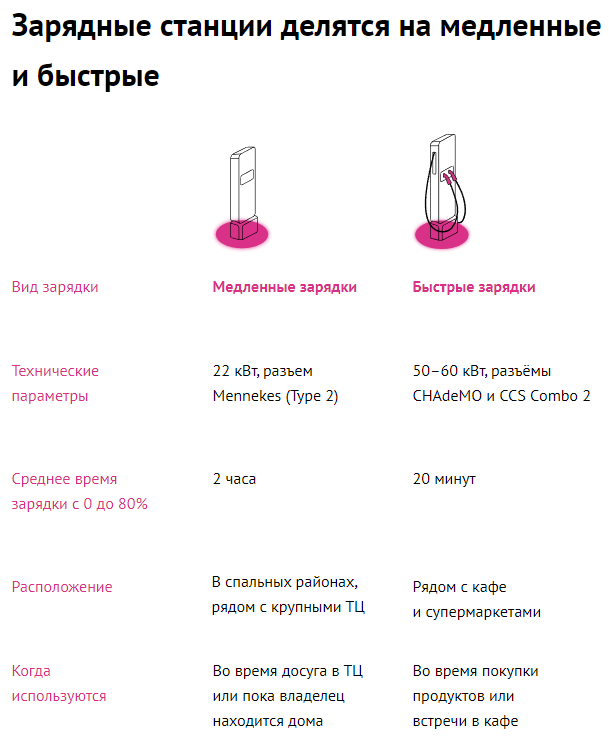

### Распределение по административным округам и районам

Рассмотрим количество заправок по административным округам Москвы:

In [39]:
stations_by_areas = (df.groupby('adm_area')['id'].count()
                      .reset_index()
                      .rename(columns={'id': 'total'})
                      .sort_values(by='total', ascending=False)
                      .reset_index(drop=True)
                      )

stations_by_areas

,adm_area,total
0,ЦАО,34
1,ЗАО,24
2,САО,20
3,ЮАО,17
4,СВАО,16
5,ЮВАО,16
6,СЗАО,13
7,ЮЗАО,13
8,ВАО,7
9,ЗелАО,2


Больше всего зарядных станций расположено в Центральном административном округе, далее по количеству идут Западный и Северный округа. Построим диаграмму распределения количества зарядных станций по округам.

In [40]:
fig = px.bar(stations_by_areas, x='adm_area', y='total',
             labels={ "adm_area": "Административный округ",  "total": "Количество зарядных станций"},
             title='Распределение зарядных станций по административным округам Москвы',
             text='total',
             color='adm_area',
             height=600)
fig.update_xaxes(tickangle=45)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside")
for data in fig.data:
    data["width"] = 0.5

fig.update_layout(showlegend=False, title_x=0.5, template='plotly_white')
fig.show()

Дополним предыдущую таблицу информацией о районах:

In [41]:
stations_by_district = (df.groupby(['adm_area', 'district'])['id'].count()
                        .reset_index()
                        .rename(columns={'id': 'total'})
                        .sort_values(by='total', ascending=False)
                        .reset_index(drop=True)
                        )

stations_by_district

,adm_area,district,total
0,ЦАО,Мещанский,10
1,СВАО,Останкинский,6
2,ЦАО,Хамовники,5
3,ЗАО,Дорогомилово,5
4,ЦАО,Тверской,4
...,...,...,...
77,СЗАО,Строгино,1
78,СЗАО,Хорошёво-Мнёвники,1
79,СЗАО,Южное Тушино,1
80,ЦАО,Арбат,1


Отобразим ТОП-10 районов по количеству зарядных станций на диаграмме:

In [42]:
fig = px.bar(stations_by_district.head(10), x='district', y='total',
             labels={ "district": "Район Москвы",  "total": "Количество зарядных станций"},
             title='ТОП-10 районов Москвы по количеству зарядных станций',
             text='total',
             color='adm_area',
             height=600)
fig.update_xaxes(tickangle=45)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside")
for data in fig.data:
    data["width"] = 0.5

fig.update_layout(title_x=0.5, template='plotly_white', legend_title="Административный округ")
fig.show()

В лидерах находится Центральный административный округ, у которого 5 районов вошли в ТОП-10. Два района Западного административного округа вошли в этот список, у других округов вошли по одному району. Половина административных округов в списке ТОП-10 по количеству зарядных станций в районах не представлена вообще.  
Есть предположение, что в двух округах (ЦАО и ЗАО) плотность расположения зарядных станций существенно выше, чем в остальных. Рассмотрим данные о среднем количестве электрозаправок в районе каждого из округов:

In [43]:
(stations_by_district.groupby('adm_area')['total'].mean()
    .round(1)
    .reset_index()
    .rename(columns={'total': 'avg_stations_quantity'})
    .sort_values(by='avg_stations_quantity', ascending=False)
    .reset_index(drop=True)
)

,adm_area,avg_stations_quantity
0,ЦАО,3.4
1,ЗАО,2.4
2,ЗелАО,2.0
3,ЮВАО,2.0
4,САО,1.8
5,СВАО,1.8
6,ЮАО,1.7
7,СЗАО,1.6
8,ЮЗАО,1.6
9,ВАО,1.0


Действительно, плотность покрытия зарядной инфраструктурой в ЦАО и ЗАО существенно выше.

Также интересно, есть ли различие в типах зарядок по округам:

In [44]:
station_type_by_area = (df.pivot_table(index='adm_area', columns='station_power', values='id', aggfunc='count', fill_value=0)
                          .reset_index()
                          .rename_axis(None, axis=1)
                       )
station_type_by_area['total'] = station_type_by_area.drop(columns='adm_area').sum(axis=1)
station_type_by_area = station_type_by_area.sort_values(by='total', ascending=False)
station_type_by_area

,adm_area,22,50,total
6,ЦАО,23,11,34
1,ЗАО,18,6,24
3,САО,16,4,20
7,ЮАО,16,1,17
4,СВАО,12,4,16
8,ЮВАО,14,2,16
5,СЗАО,11,2,13
9,ЮЗАО,13,0,13
0,ВАО,7,0,7
2,ЗелАО,1,1,2


Для наглядности построим диаграмму структуры и количества зарядных станций по административным округам (за исключением Зеленограда, т.к. он находится далеко от центра и имеет всего по одной электрозаправке каждого типа):

In [45]:
# группировка данных с количеством зарядок разного типа по округам
data = (df.query('adm_area != "ЗелАО"').groupby(['adm_area', 'station_power'])['id']
        .count().reset_index()
        .rename(columns={'id': 'total'})
       )
# расчет процента типа зарядных станций по каждому округу
data['percent'] = ((data['total'] / data.groupby('adm_area')['total'].transform('sum'))
                    .map('{:,.1%}'.format)
                  )

fig = px.bar(data,
             x='adm_area', y='total',
             labels={ "adm_area": "Административный округ",  "total": "Количество зарядных станций"},
             title='Структура и количество зарядных станций по округам Москвы',
             text='percent',
             color=data['station_power'].astype('object'),
             height=600)
fig.update_xaxes(tickangle=45)

for data in fig.data:
    data["width"] = 0.5


fig.update_layout(title_x=0.5, template='plotly_white', legend_title="Мощность, кВт")
fig.show()

### Заключение

В ходе исследовательского анализа данных определено, что в г. Москва установлены два типа зарядных станций:


*   мощностью 22 кВт (т.н. "медленные")
*   мощностью 50 кВт (т.н. "быстрые")

Всего в загруженном датасете имеется информация о 162 электрозаправках, при этом станций мощностью 50 кВт примерно в 4 раза меньше, чем станций мощностью 22 кВт (19% и 81% соответственно).

Построено распределение по административным округам и районам.  
Лидерами по количеству электрозаправок являются Центральный, Западный и Северный административные округа.  
Распределение по районам показало, что 5 из 10 районов с самым большим количеством зарядных станций находятся в Центральном административном округе, два находятся в Западном административном округе. Также в ТОП-10 вошли по одному району из Северо-Восточного, Северо-Западного и Юго-Восточного административных округов. Районы из остальных округов в данный список не вошли.

Рассмотрены данные о среднем количестве электрозаправок в районе каждого из округов - плотность покрытия зарядной инфраструктурой в ЦАО и ЗАО существенно выше по сравнению с остальными.

Построена диаграмма структуры и количества зарядных станций по административным округам. В ЦАО наибольшее количество электрозаправок, причем доля быстрых зарядных станций (32,4%) намного превышает показатели других округов - к примеру в ЗАО и СВАО доля быстрых зарядных станций составляет 25%, для других округов данный показатель еще ниже, а в некоторых округах (ВАО и ЮЗАО) быстрые зарядки вовсе не установлены.

## Визуализация геоданных

### Загрузка географических границ Москвы

Загрузим данные с административными границами Москвы:

In [46]:
path = "/content/drive/MyDrive/Colab Notebooks/Данные/Геоданные Москвы/mo.shp"

mo_gdf = gpd.read_file(path)
mo_gdf.head()

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.42765 55.74821, 37.42849 55.74875..."
2,Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.80357 55.45162, 36.80451 55.46551..."
3,Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.93724 55.24139, 36.93726 55.24161..."
4,"""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.43956 55.62731, 37.44018 55.63042..."


Построим карту Москвы:

<Axes: >

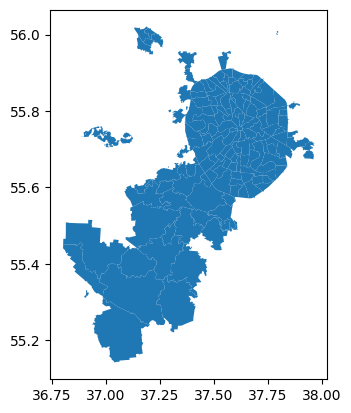

In [47]:
mo_gdf.plot()

Предлагается поправить наименования столбцов в соответствии со змеиным регистром, переименовать столбец с названием районов, убрать из датафрейма `mo_gdf` округа, где нет зарядных станций:

In [48]:
# приведем к нижнему регистру
mo_gdf.columns = mo_gdf.columns.str.lower()
mo_gdf.rename(columns={'name': 'district'}, inplace=True)
mo_gdf.head()

,district,okato,oktmo,name_ao,okato_ao,abbrev_ao,type_mo,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.42765 55.74821, 37.42849 55.74875..."
2,Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.80357 55.45162, 36.80451 55.46551..."
3,Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.93724 55.24139, 36.93726 55.24161..."
4,"""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.43956 55.62731, 37.44018 55.63042..."


In [49]:
# рассмотрим аббревиатуры административных округов
mo_gdf['abbrev_ao'].unique()

array(['Троицкий', 'ЗАО', 'Новомосковский', 'ЗелАО', 'СЗАО', 'ЮАО', 'САО',
       'ЮЗАО', 'ЦАО', 'СВАО', 'ВАО', 'ЮВАО'], dtype=object)

In [50]:
# список административных округов с зарядными станциями
adm_area = df['adm_area'].unique().tolist()

In [51]:
# оставим только административные округа, где расположены зарядные станции:
mo_gdf = mo_gdf.query('abbrev_ao in @adm_area')

In [52]:
# список оставшихся административных округов
mo_gdf['abbrev_ao'].unique()

array(['ЗАО', 'ЗелАО', 'СЗАО', 'ЮАО', 'САО', 'ЮЗАО', 'ЦАО', 'СВАО', 'ВАО',
       'ЮВАО'], dtype=object)

<Axes: >

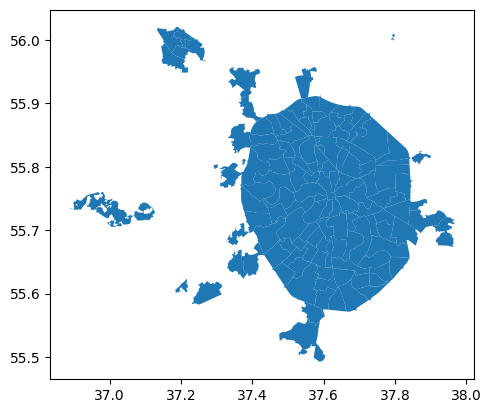

In [53]:
# карта Москвы с оставшимися административными округами
mo_gdf.plot()

Перейдем в географическую систему координат EPSG:3857, используемую, например, в Google Maps:

In [54]:
mo_gdf = mo_gdf.to_crs('EPSG:3857')

Для построения интерактивной карты с информацией о зарядных станциях предлагается использовать библиотеку для визуализации данных `Plotly`. Подготовим данные.

### Обработка геометрии и построение слоя-подложки

Преобразуем полигоны и мультиполигоны в шэйпы, которые способна считывать для построения `Plotly`. Предлагается использовать класс `go.Scatter`, следовательно необходимо перевести геометрии в формат отдельных массивов координат `x` и `y` с помощью функции `geom2shape`:

In [55]:
# отключим ворнинги
pd.options.mode.chained_assignment = None

In [56]:
def geom2shape(g):
    """Преобразование полигонов и мультиполигонов в plotly-readable шэйпы

    Получает на вход Polygon или MultiPolygon из geopandas,
    возвращает pd.Series с координатами x и y
    """
    # Если мультиполигон, то преобразуем каждый полигон отдельно, разделяя их None'ами
    if type(g) == MultiPolygon:
        x, y = np.array([[], []])
        for poly in g.geoms:
            x_, y_ = poly.exterior.coords.xy
            x, y = (np.append(x, x_), np.append(y, y_))
            x, y = (np.append(x, None), np.append(y, None))
        x, y = x[:-1], y[:-1]
    # Если полигон, то просто извлекаем координаты
    elif type(g) == Polygon:
        x, y = np.array(g.exterior.coords.xy)
    # Если что-то другое, то возвращаем пустые массивы
    else:
        x, y = np.array([[], []])
    return pd.Series([x,y])

In [57]:
# Преобразование полигонов в шейпы
mo_gdf[['x','y']] = mo_gdf['geometry'].apply(geom2shape)

In [58]:
mo_gdf.head()

,district,okato,oktmo,name_ao,okato_ao,abbrev_ao,type_mo,geometry,x,y
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((4166426.928 7508453.650, 4166520.036...","[4166426.928456916, 4166520.0360790165, 416664...","[7508453.649767973, 7508560.652202924, 7508687..."
9,Матушкино,45272562,45331000,Зеленоградский,45272000,ЗелАО,Муниципальный округ,"POLYGON ((4138694.961 7559998.797, 4138950.785...","[4138694.9612507513, 4138950.7845725426, 41390...","[7559998.797434156, 7560057.376609616, 7560082..."
10,Внуково,45268552,45317000,Западный,45268000,ЗАО,Муниципальный округ,"MULTIPOLYGON (((4144447.663 7476303.889, 41450...","[4144447.6631042706, 4145022.7952534542, 41450...","[7476303.888757415, 7476547.162161036, 7477055..."
11,Савёлки,45272568,45377000,Зеленоградский,45272000,ЗелАО,Муниципальный округ,"POLYGON ((4142138.518 7558580.609, 4142170.823...","[4142138.5183789497, 4142170.823295178, 414218...","[7558580.608673893, 7558591.7370294565, 755859..."
13,Силино,45272572,45332000,Зеленоградский,45272000,ЗелАО,Муниципальный округ,"POLYGON ((4133471.038 7561690.266, 4133588.714...","[4133471.0381104476, 4133588.713944165, 413374...","[7561690.266458496, 7561756.207449855, 7561946..."


In [59]:
class mapFigure(go.Figure):
    """ Шаблон фигуры для рисования поверх карты Москвы
    """
    def __init__(self, # дефолтные параметры plotly
        data=None, layout=None, frames=None, skip_invalid=False,
        **kwargs # аргументы (см. документацию к plotly.graph_objects.Figure())
    ):
        # создаём plotlу фигуру с дефолтными параметрами
        super().__init__(data, layout, frames, skip_invalid, **kwargs)

        # прорисовка районов
        for i, r in mo_gdf.iterrows():
            self.add_trace(go.Scatter(x=r.x, y=r.y,
                                      name=r['district'],
                                      text=r['district'],
                                      hoverinfo="text",
                                      line_color='grey',
                                      fill='toself',
                                      line_width=1,
                                      fillcolor='lightblue',
                                      showlegend=False
            ))

        # не отображать оси, уравнять масштаб по осям
        self.update_xaxes(visible=False)
        self.update_yaxes(visible=False, scaleanchor="x", scaleratio=1)

        # чтобы покрасивее вписывалась карта на поверхности фигуры
        self.update_layout(showlegend=False, dragmode='pan',
                           width=1200, height=800,
                           margin={'l': 10, 'b': 10, 't': 10, 'r': 10},
                           template='plotly_white')

In [60]:
moscow_map = mapFigure()
moscow_map.show()

Получилась знакомая карта Москвы с информацией о названиях районов. Дополним карту уникальным цветом для каждого административного округа и его названием:

In [61]:
colors = px.colors.qualitative.Plotly
fo_list = list(mo_gdf['abbrev_ao'].unique())

for i, r in mo_gdf.iterrows():
  text = f'<b>{r["district"]}</b><br>{r["abbrev_ao"]}'
  moscow_map.update_traces(selector=dict(name=r['district']),
                           text=text,
                           fillcolor=colors[fo_list.index(r['abbrev_ao'])])


In [62]:
moscow_map.show()

### Привязка зарядных станций

Для того, чтобы отметить на карте зарядные станции, соберем геодатафрейм, используя парные значения в столбцах `longitude` (долгота) и `latitude` (широта):

In [63]:
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = GeoDataFrame(df, geometry=geometry)

Исходные геоданные были в геодезической системе координат WGS84 (см. раздел "Загрузка данных"), что соответствует EPSG:4326.

In [64]:
# установка исходной географической системы координат
gdf = gdf.set_crs(epsg=4326, inplace=True)

Переведем геоданные в выбраную географическую систему координат EPSG:3857.

In [65]:
# перевод в систему координат EPSG:3857
gdf = gdf.to_crs(epsg=3857)

In [66]:
gdf.head()

,id,adm_area,district,address,longitude,latitude,global_id,station_name,station_power,geometry
1,2,ЦАО,Замоскворечье,"Российская Федерация, город Москва, внутригоро...",37.635730,55.734530,2566160457,Станция №2,22,POINT (4189590.299 7505748.583)
2,71,ЦАО,Таганский,"Российская Федерация, город Москва, внутригоро...",37.655510,55.736310,2566160494,Станция №71,22,POINT (4191792.199 7506100.525)
3,72,ЦАО,Таганский,"Российская Федерация, город Москва, внутригоро...",37.655608,55.736211,2566160642,Станция №72,22,POINT (4191803.108 7506080.950)
4,73,ЗАО,Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.571088,55.743311,2566178202,Станция №73,50,POINT (4182394.385 7507484.920)
5,74,ЗАО,Дорогомилово,"Российская Федерация, город Москва, внутригоро...",37.570948,55.743153,2566178211,Станция №74,50,POINT (4182378.800 7507453.674)


Добавим информацию по размещению зарядных станций на карту Москвы:

In [67]:
moscow_map.add_trace(go.Scatter(
    x = gdf['geometry'].x, y = gdf['geometry'].y, name='зарядные станции',
    text = "<b>"+gdf['station_name']+"</b><br>Мощность <b>"+gdf['station_power'].astype('str')+ " кВт""</b>",
    hoverinfo="text", showlegend=False, mode='markers',
    marker_size=df['station_power'], marker_sizemode='area',
    marker_color = df['station_power']
))

moscow_map.show()

Геоданные успешно привязаны в выбранной системе географических координат. Карта полностью интерактивная и позволяет получить основную информацию о названии зарядной станции, ее мощности, району расположения.  
Для удобства зарядные станции в зависимости от типа (быстрые или медленные) выделены отдельными цветами и размерами маркеров на карте.

### Заключение

В данном разделе выполнена загрузка данных с административными границами Москвы (геодатафрейм `mo_gdf`), выполнено преобразование полигонов и мультиполигонов в географическую систему координат EPSG:3857, используемую, например, в Google Maps.

Для целей дальнейшей визуализации и построения интерактивной карты выбрана библиотека `Plotly`, подготовлены данные:
* геометрии переведены в формат отдельных массивов координат `x` и `y` с помощью функции `geom2shape`
* подготовлен шаблон фигуры для рисования поверх карты Москвы
* подготовлена карта Москвы с уникальными цветами для каждого административного округа и названиями районов и округов.

**Важно, что данная карта (слой-подложка) является универсальной для анализа геоданных любых объектов Москвы, имеющих территориальную привязку (например: предприятия быстрого питания, офисные здания, паркинги, котельные и т.п.).**

Для привязки зарядных станций к подготовленной карте выполнен перевод геоданных в выбраную географическую систему координат EPSG:3857. Зарядные станции в зависимости от типа (быстрые или медленные) выделены отдельными цветами и размерами маркеров на карте.

Геоданные успешно привязаны в выбранной системе географических координат. Карта полностью интерактивная и позволяет получить основную информацию о названии зарядной станции, ее мощности, району расположения.

Для быстрых зарядных станций характерно тяготение к центру, на перифирии (за небольшим исключением) они не представлены.

Медленные зарядные станции расположены как в центре, так и на перифирии (в том числе и за МКАДом в небольшом количестве). Предварительно отмечено, что характер распределения части зарядных станций коррелирует с большими вылетными магистралями (например: Ленинградское шоссе, Варшавское шоссе, Ярославское шоссе).

Зарядных станций практически нет в промзонах и прилегающих территориях.
В ВАО визуально плотность распределения заправок самая низкая по сравнению с остальными округами.



## Общий вывод

Выполнено комплексное исследование по характеру и типу распределения зарядных станций в г. Москва.

Исходные данные получены с портала https://data.mos.ru/opendata/, выполнена их предобработка:

1. из датасета удалена лишняя информация:
 * удалена первая строка, которая содержит пояснения об информации в столбце на русском языке
 * удален столбец `object_category_Id`, т.к. он полностью пустой
2. выполнено разделение строковых данных из оригинального столбца `Name` на название заправок и их мощность, данные сохранены в столбцах `station_name` и `station_power` соответственно.
3. названия столбцов приведены к единому стилю (змеиный регистр)
4. выполнена проверка данных на пропуски, пропусков не обнаружено
5. выполнена проверка данных на явные и неявные дубликаты, дубликатов не обнаружено.
6. выполнена оптимизация текстовых данных в столбцах `adm_area` и `district`:
 * сокращены названия административных округов
 * удалено слово "район" из названий районов
7. преобразованы типы данных:
 * `id` : *object → int32*
 * `longitude`: *object → float64*
 * `latitude`: *object → float64*
 * `global_id`: *object → int64*
 * `station_power`: *object → int32*

В ходе исследовательского анализа данных определено, что в г. Москва установлены два типа зарядных станций:


*   мощностью 22 кВт (т.н. "медленные")
*   мощностью 50 кВт (т.н. "быстрые")

Всего в загруженном датасете имеется информация о 162 электрозаправках, при этом станций мощностью 50 кВт примерно в 4 раза меньше, чем станций мощностью 22 кВт (19% и 81% соответственно).

Построено распределение по административным округам и районам.  
Лидерами по количеству электрозаправок являются Центральный, Западный и Северный административные округа.  
Распределение по районам показало, что 5 из 10 районов с самым большим количеством зарядных станций находятся в Центральном административном округе, два находятся в Западном административном округе. Также в ТОП-10 вошли по одному району из Северо-Восточного, Северо-Западного и Юго-Восточного административных округов. Районы из остальных округов в данный список не вошли.

Рассмотрены данные о среднем количестве электрозаправок в районе каждого из округов - плотность покрытия зарядной инфраструктурой в ЦАО и ЗАО существенно выше по сравнению с остальными.

Построена диаграмма структуры и количества зарядных станций по административным округам. В ЦАО наибольшее количество электрозаправок, причем доля быстрых зарядных станций (32,4%) намного превышает показатели других округов - к примеру в ЗАО и СВАО доля быстрых зарядных станций составляет 25%, для других округов данный показатель еще ниже, а в некоторых округах (ВАО и ЮЗАО) быстрые зарядки вовсе не установлены.

Выполнена привязка геоданных по заправочным станциям к карте Москвы.
Для этой цели выполнена загрузка данных с административными границами Москвы (геодатафрейм `mo_gdf`), выполнено преобразование полигонов и мультиполигонов в географическую систему координат EPSG:3857, используемую, например, в Google Maps.

Для целей дальнейшей визуализации и построения интерактивной карты была выбрана библиотека `Plotly`, подготовлены данные:
* геометрии переведены в формат отдельных массивов координат `x` и `y` с помощью функции `geom2shape`
* подготовлен шаблон фигуры для рисования поверх карты Москвы
* подготовлена карта Москвы с уникальными цветами для каждого административного округа и названиями районов и округов.

**Важно, что данная карта (слой-подложка) является универсальной для анализа геоданных любых объектов Москвы, имеющих территориальную привязку (например: предприятия быстрого питания, офисные здания, паркинги, котельные и т.п.).**

Для привязки зарядных станций к подготовленной карте выполнен перевод геоданных в выбраную географическую систему координат EPSG:3857. Зарядные станции в зависимости от типа (быстрые или медленные) выделены отдельными цветами и размерами маркеров на карте.

Геоданные успешно привязаны в выбранной системе географических координат. Карта полностью интерактивная и позволяет получить основную информацию о названии зарядной станции, ее мощности, району расположения.

Для быстрых зарядных станций характерно тяготение к центру, на перифирии (за небольшим исключением) они не представлены.

Медленные зарядные станции расположены как в центре, так и на перифирии (в том числе и за МКАДом в небольшом количестве). Предварительно отмечено, что характер распределения части зарядных станций коррелирует с большими вылетными магистралями (например: Ленинградское шоссе, Варшавское шоссе, Ярославское шоссе).

Зарядных станций практически нет в промзонах и прилегающих территориях.
В ВАО визуально плотность распределения заправок самая низкая по сравнению с остальными округами.

**По итогам анализа данных можно сделать вывод о низком развитии зарядной инфраструктуры и неравномерном распределении зарядных станций в Москве, что в конечном итоге сильно тормозит переход с автомобилей на электрокары, несмотря на более низкую стоимость владения, налоговые послабления и прочие преимущества, например как бесплатную парковку в центре и бесплатный проезд по платным магистралям.**

Предлагается детально рассмотреть факторы, ограничивающие развитие зарядной инфраструктуры (отсутствие выделенных мощностей, согласованные мэрией места установки зарядок, оптимизация бизнес-модели в части снижения капитальных и эксплуатационных затрат и прочее).
